# Project

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm 
from scipy import stats
import itertools
from iminuit import Minuit   
from scipy.optimize import minimize
import sys  
from importlib import reload
from scipy import interpolate
import copy
import pandas as pd
import math

# external libraries
sys.path.append('../') 
import AdvAppStatFunctions as aas

# setting for plotting
import seaborn as sns
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
sns.set_palette("Paired")
color = sns.color_palette("Paired")

## Parsing data

In [2]:
ratios = pd.read_csv('Data_ratios_elections.csv', delimiter=',')
presidents = pd.read_csv('Data_presidents_elections.csv', delimiter=',')
    
# turn all commas into dots
for i in range(len(ratios.keys())-1):
    ratios[ratios.keys()[i+1]] = ratios[ratios.keys()[i+1]].str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)
    
# turn all strings into floats
ratios.astype({col: float for col in ratios.columns[1:]})
presidents.astype({col: float for col in presidents.columns[1:]});

/var/folders/5c/kvpjh5n11_j2mp3l99c22xdr0000gn/T/ipykernel_1442/2450889468.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  ratios[ratios.keys()[i+1]] = ratios[ratios.keys()[i+1]].str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)


In [3]:
# two different x axis
# option 1
years = pd.Series(np.linspace(2003.50,2022.75,78))
idx_drop = (1, 2, 16)

for idx in idx_drop:
    years = years.drop(idx)

# option 2
xaxis = ratios.keys()[1:]
xaxis_cut = xaxis[::10]
    
# other
N_data = len(ratios['Country'])
N_years = len(ratios.keys()[1:])

# Reshaping data

In [4]:
r_ji = ratios.drop(['Country'], axis=1)/100
f_ji = presidents.drop(['Country'], axis=1)

In [5]:
f_ji_gns = []

for i in range(N_data):
    f_ji_gns.append(np.nanmean(f_ji.iloc[i]))
    
r_ji_gns = []

for i in range(N_data):
    r_ji_gns.append(np.nanmean(r_ji.iloc[i]))

# HBI model

In [6]:
n = N_data  # j groups
m = N_years  # i times

### Theta function

In [7]:
#theta_ji = theta_ji_func(starting_values)

### Log-Likelihood

We model
the number of women laureates, fij, within the scientific field j, in year i as a stochastic binomial variable:

p is the probability of success in each trial

q is the probability of failure in each trial, q = 1 - p

n is number of trials

k is the number of successes which can occur anywhere among the n trials

In [8]:
from scipy.special import logit

def sigmoid(x):
      return 1 / (1 + math.exp(-x))

def log_likelihood(f_ji, pars):
    theta_ji = np.zeros(shape=(n, m))
    loglike = 0
    
    for j in range(n):
        for i in range(m):
            theta_ji[j][i] = sigmoid(logit(r_ji.iloc[j, i]) + pars['log_alpha_j'][j])
            #theta_ji[j][i] = r_ji.iloc[j, i]*pars['alpha_j'][j]
            loglike_pos = scipy.stats.binom.logpmf(k = f_ji.iloc[j][i], n = 1, p = theta_ji[j][i])
            if math.isnan(loglike_pos) == False:
                loglike += loglike_pos
            
    return loglike

### Prior

In [9]:
def log_prior(pars):
    log_alpha_prior = np.sum(stats.norm.logpdf(pars['log_alpha_j'], pars['mu'], pars['sigma']))
    mu_prior = stats.norm.logpdf(pars['mu'], 0, 1)
    sigma_prior = stats.norm.logpdf(pars['sigma'], 1, 0.5)
    
    return log_alpha_prior + mu_prior + sigma_prior

### Posterior

In [10]:
def log_posterior(f_ji, pars):
    return log_likelihood(f_ji, pars) + log_prior(pars)

### Setting up sampler

In [11]:
def proposals(pars, proposal_sd):
    new_pars = copy.deepcopy(pars)
    for i in list(new_pars.keys()):
        if type(new_pars[i]) == np.ndarray:
            for j in range(len(new_pars[i])):
                new_pars[i][j] += np.random.normal(0, proposal_sd)
        if type(new_pars[i]) == float:
            new_pars[i] += np.random.normal(0, proposal_sd)
    return new_pars

In [12]:
def metropolis(n_it, proposal_sd, f_ji, starting_values):
    alpha_j, mu, sigma = [], [], []
    n_accept = 0
    current_draw = copy.deepcopy(starting_values)
    
    for t in range(n_it):
        proposal = proposals(current_draw, proposal_sd)

        if proposal['sigma'] <= 0:
            acceptance_ratio = 0
        
        else:
            acceptance_ratio = np.exp(log_posterior(f_ji, proposal) - log_posterior(f_ji, current_draw))

        random_threshold = np.random.uniform(0, 1)
        if acceptance_ratio > 1 or random_threshold <= acceptance_ratio:
            current_draw = proposal #copy.deepcopy(proposal)
            n_accept += 1

        alpha_j.append(copy.deepcopy(current_draw['log_alpha_j']))
        mu.append(current_draw['mu'])
        sigma.append(current_draw['sigma'])

    accept_rate = n_accept/n_it
    return alpha_j, mu, sigma, accept_rate

In [13]:
starting_values = {'log_alpha_j': np.random.normal(0, 1, n),
                   'mu': np.random.normal(0, 1),
                   'sigma': np.random.normal(1, 0.5)}

In [33]:
%%time
n_it = 5000
results = metropolis(n_it, proposal_sd=0.125, f_ji=f_ji,starting_values=starting_values)

CPU times: user 16min 22s, sys: 2.08 s, total: 16min 25s
Wall time: 16min 25s


In [34]:
# MEANS 
log_alphas = results[0]
log_alphas_sel = log_alphas[1000:]
mus = results[1]
sigmas = results[2]

log_alpha_gns = []
for j in range(n):
    log_alpha_j = []
    for i in range(n_it-1000):
        log_alpha_j.append(log_alphas_sel[i][j])
    log_alpha_j_gns = sum(log_alpha_j)/len(log_alpha_j)
    log_alpha_gns.append(log_alpha_j_gns)
    
alpha_gns = np.exp(log_alpha_gns)

In [35]:
# MEDIANS

log_alpha_med = []
for j in range(n):
    log_alpha_j = []
    for i in range(n_it-1000):
        log_alpha_j.append(log_alphas_sel[i][j])
    log_alpha_j_med = np.median(log_alpha_j)
    log_alpha_med.append(log_alpha_j_med)
    
alpha_med = np.exp(log_alpha_med)

In [36]:
# Number of election and female politic leaders
n_elections = np.sum(np.sum(r_ji > 0))
n_women = np.sum(np.sum(f_ji > 0.5))
print(n_elections, n_women, n_women/n_elections)

### Plot of all log alpha values for all countries in one plot

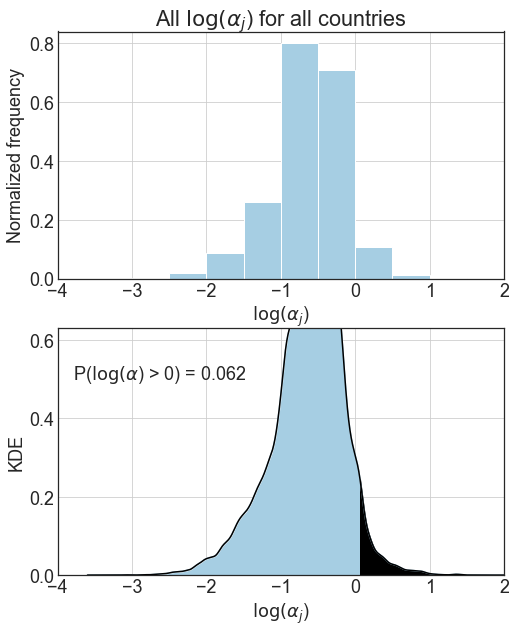

In [41]:
log_alphas_sel_all = np.concatenate(log_alphas_sel)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))
ax1.hist(log_alphas_sel_all, range=(-4,2), bins=12, density=True)
ax1.grid()
ax1.set(xlabel = r'$\log(\alpha_j$)', ylabel='Normalized frequency', xlim=(-4,2),  title=r'All $\log(\alpha_j$) for all countries')

kde = stats.gaussian_kde(log_alphas_sel_all, bw_method='silverman')
data_space = np.linspace(min(log_alphas_sel_all)-0.5,max(log_alphas_sel_all)+0.5, 1000) 
evaluated_kde = kde.evaluate(data_space)

ax2.plot(data_space, evaluated_kde)
ax2.fill_between(data_space, evaluated_kde)

prob = aas.integrate(data_space, evaluated_kde, 0, max(data_space))
ax2.text(-3.8, 0.5, r'P($\log(\alpha$) > 0) = %s' %(round(prob,3)))
ax2.fill_between(data_space[651:], evaluated_kde[651:], color='black')
ax2.plot(data_space, evaluated_kde, color='black')
ax2.set(xlabel = r'$\log(\alpha_j$)', ylabel=r'KDE', ylim=(0,0.63), xlim=(-4,2))
ax2.grid()
fig.savefig('All_contries');

In [42]:
country_codes = ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'GR', 'ES', 'FI', 'FR', 'HR', 'HU',
                 'IE', 'IS', 'IT', 'LI', 'LT', 'LU', 'LV', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 
                 'SE', 'SI', 'SK', 'TR', 'GB']

### MHMC steps for Denmark

In [24]:
all_log_alpha_j = []
for j in range(n):
    log_alpha_j = []
    for i in range(n_it-1000):
        log_alpha_j.append(log_alphas_sel[i][j])
    all_log_alpha_j.append(log_alpha_j)
    
all_alpha_j = np.exp(all_log_alpha_j)

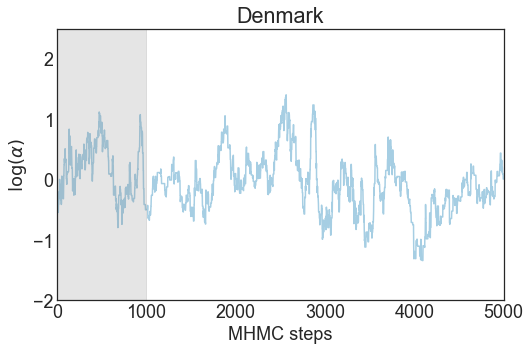

In [32]:
log_alpha_dk = []
for i in range(n_it):
    log_alpha_dk.append(log_alphas[i][5])

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(log_alpha_dk, zorder=0)
ax.fill_between(np.linspace(0,1000,100),np.ones(100)*(-2), np.ones(100)*2.5, color='grey', alpha=0.2)
#ax.hlines(np.median(log_alpha_dk[1000:]), 1000, 5000, color='black', ls='dashed', zorder=1, label='Median')
ax.set(title='Denmark', xlabel='MHMC steps', ylabel=r'$\log(\alpha)$', xlim=(0,5000), ylim=(-2,2.5))
#ax.legend(loc='lower right')
fig.savefig('MHMCsteps');

### Plot of log alpha values for the four chosen countries

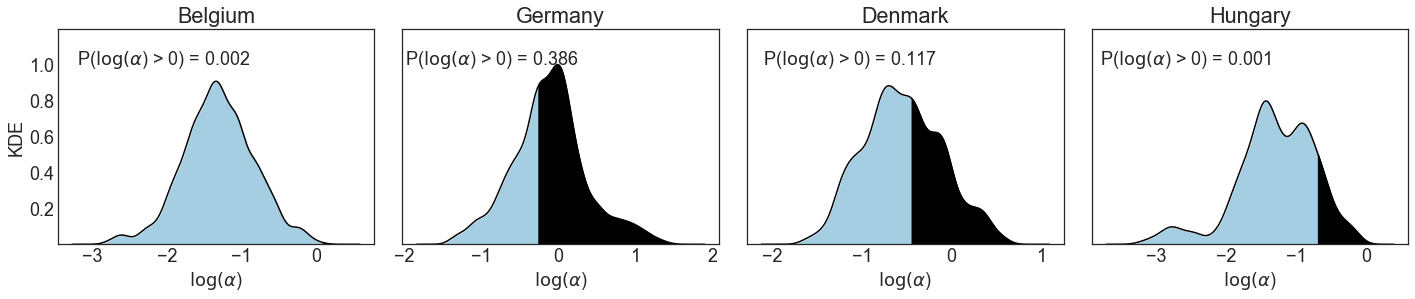

In [44]:
chosen = ['Belgium', 'Germany', 'Denmark', 'Hungary']
chosen_idxs = [1, 5, 6, 13]
        
fig, axes = plt.subplots(1,4, figsize=(20, 4.5), sharey=True)

prob_alpha_chosen = []
idx0_all = []
data_spaces = []
kdes = []

for idx, i in enumerate(chosen_idxs):
    kde = stats.gaussian_kde(all_log_alpha_j[i], bw_method='silverman')
    data_space = np.linspace(min(all_log_alpha_j[i])-0.5,max(all_log_alpha_j[i])+0.5, 1000) 
    evaluated_kde = kde.evaluate(data_space)
    
    if max(data_space) < 0: prob_alpha_chosen.append(0)
    else: 
        prob = aas.integrate(data_space, evaluated_kde, 0, max(data_space))
        prob_alpha_chosen.append(prob)
        
    axes[idx].plot(data_space, evaluated_kde, color='black')
    axes[idx].fill_between(data_space, evaluated_kde)
    axes[idx].set(title=chosen[idx], xlabel=r'$\log(\alpha$)', ylim=(0,1.2),
                 yticks = np.linspace(0.2,1,5), yticklabels=[0.2, 0.4, 0.6, 0.8, 1.0])
    
    idx0 = np.where(np.isclose(data_space, np.zeros_like(data_space)*0,rtol=1e-3)==True)[0]
    idx0_all.append(idx0)
    data_spaces.append(data_space)
    kdes.append(evaluated_kde)
    
  

axes[0].set(ylabel=r'KDE')
axes[0].text(-3.2, 1., r'P($\log(\alpha$) > 0) = %s' %(round(prob_alpha_chosen[0],3)))
axes[0].fill_between(data_spaces[0][870:], kdes[0][870:], color='black')
axes[1].text(-2, 1., r'P($\log(\alpha$) > 0) = %s' %(round(prob_alpha_chosen[1],3)))
axes[1].fill_between(data_spaces[1][422:], kdes[1][422:], color='black')
axes[2].text(-2.1, 1., r'P($\log(\alpha$) > 0) = %s' %(round(prob_alpha_chosen[2],3)))
axes[2].fill_between(data_spaces[2][521:], kdes[2][521:], color='black')
axes[3].text(-3.8, 1., r'P($\log(\alpha$) > 0) = %s' %(round(prob_alpha_chosen[3],3)))
axes[3].fill_between(data_spaces[3][735:], kdes[3][735:], color='black')

fig.tight_layout()
fig.savefig('KDEs')

In [45]:
plt.rcParams['font.size'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12

In [46]:
country_names = pd.read_csv('OLD_Data_presidents.csv', delimiter=';').iloc[:,0]


# drop four rows in ratios and presidents: total
idx_drop = [0, 2, 10, 13, 14, 20, 27, 41]
for idx in idx_drop:
    country_names = country_names.drop(idx)

### Plot of log alpha values for the all countries in seperate plots

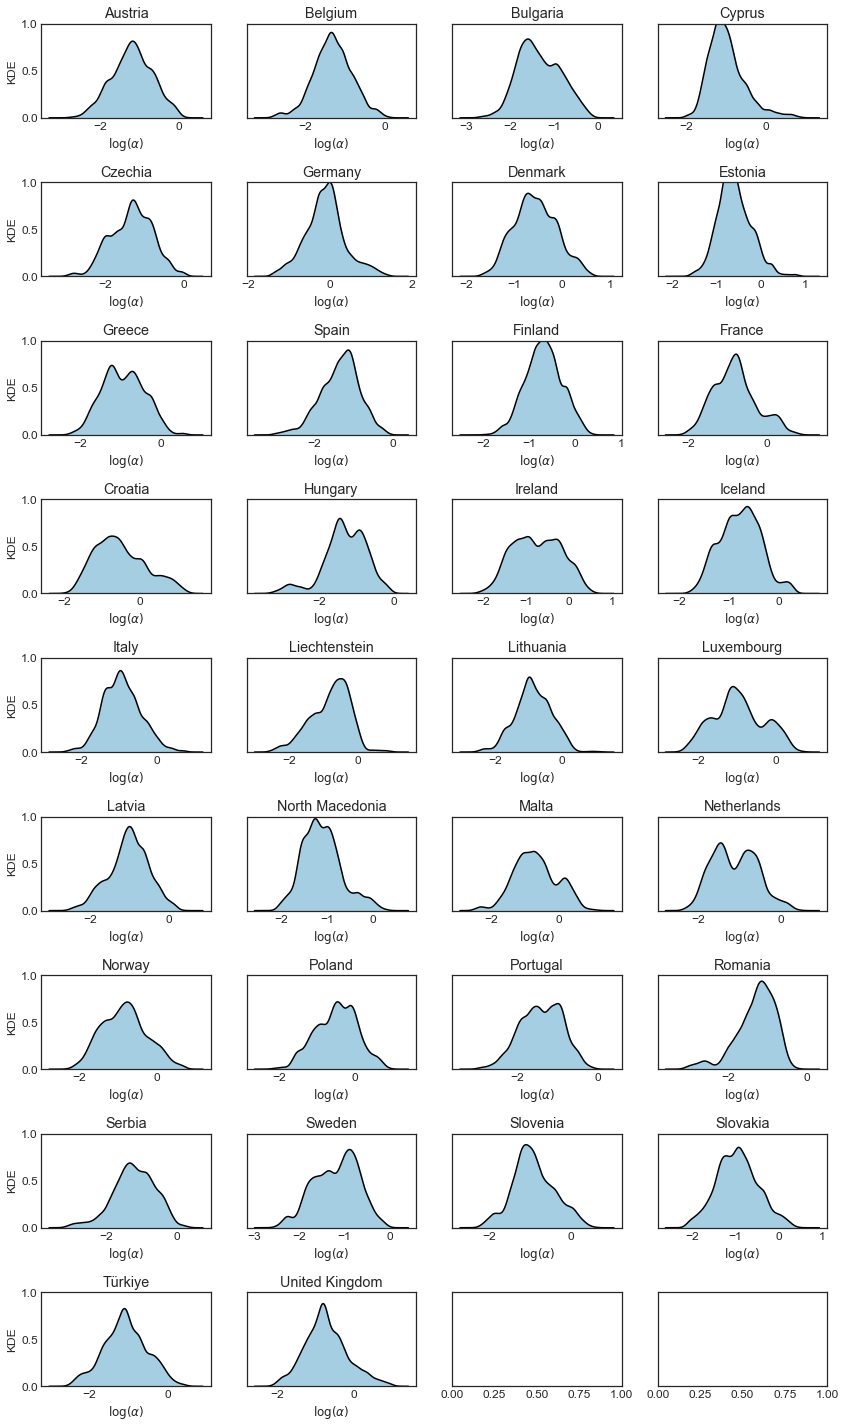

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

fig, axes = plt.subplots(9, 4, figsize=(12, 20), sharey=True)

prob_alpha = []

for i in range(34):
    r = i // 4
    c = i % 4
    

    axes[r][c].set(title=country_names.iloc[i], xlabel=r'$\log(\alpha)$', ylim=(0,1.))
    kde = stats.gaussian_kde(all_log_alpha_j[i], bw_method='silverman')
    data_space = np.linspace(min(all_log_alpha_j[i])-0.5,max(all_log_alpha_j[i])+0.5, 1000) 
    evaluated_kde = kde.evaluate(data_space)
    axes[r][c].plot(data_space, evaluated_kde, color='black')
    axes[r][c].fill_between(data_space, evaluated_kde, color=color[0])  # add alpha value
    
    if max(data_space) < 0: 
        prob_alpha.append(0)
        #axes[r][c].text(min(all_log_alpha_j[i]), max(evaluated_kde), 'p = 0.0')
    else: 
        prob = aas.integrate(data_space, evaluated_kde, 0, max(data_space))
        prob_alpha.append(prob)
        #axes[r][c].text(min(all_log_alpha_j[i]), max(evaluated_kde), f'p = {round(prob,3)}')
        
    if c==0:
        axes[r][c].set_ylabel('KDE')
        
# ylabel=r'P ($\log(\alpha)$)')
plt.tight_layout()  # adjust the subplot layout
plt.show()  # show the plot
fig.savefig('KDEs_all'); 

In [48]:
print("\\begin{table*}")
print("\\small")
print("\\centering")
print("\t \\begin{tabular}{c|ccccc}")
print("\t \t \\hline")
print("\t \t \\hline")
print("\t \t {0:8s} & {1:11s} & {2:5s} & {3:5s} & {4:5s} \\\\".format( "Country", "W:M parliament", "W:M leaders", r"$\log(\alpha)$", r"P($\log(\alpha)$ > 0)"))
print("\t \t \\hline")

for country, m_ratio, m_pres, a_med, p_a in zip(country_codes, r_ji_gns, f_ji_gns, log_alpha_med, prob_alpha):
    print(f"\t \t {country}  & \t {m_ratio:2.3f} & \t {m_pres:2.3f} & \t {a_med:2.3f}  & \t {p_a:2.3f}    \\\\")
    
print("\t \t \\hline")
print("\t \\end{tabular}")
print("\\end{table*}")

\begin{table*}
\small
\centering
	 \begin{tabular}{c|ccccc}
	 	 \hline
	 	 \hline
	 	 Country  & W:M parliament & W:M leaders & $\log(\alpha)$ & P($\log(\alpha)$ > 0) \\
	 	 \hline
	 	 AT  & 	 0.345 & 	 0.100 & 	 -0.532  & 	 0.005    \\
	 	 BE  & 	 0.384 & 	 0.100 & 	 -0.955  & 	 0.002    \\
	 	 BG  & 	 0.237 & 	 0.000 & 	 -0.688  & 	 0.000    \\
	 	 CY  & 	 0.147 & 	 0.067 & 	 -0.718  & 	 0.042    \\
	 	 CZ  & 	 0.182 & 	 0.000 & 	 -0.629  & 	 0.004    \\
	 	 DE  & 	 0.327 & 	 0.800 & 	 -0.269  & 	 0.386    \\
	 	 DK  & 	 0.382 & 	 0.429 & 	 -0.375  & 	 0.117    \\
	 	 EE  & 	 0.224 & 	 0.200 & 	 -0.582  & 	 0.064    \\
	 	 GR  & 	 0.187 & 	 0.100 & 	 -0.516  & 	 0.032    \\
	 	 ES  & 	 0.367 & 	 0.000 & 	 -0.764  & 	 0.000    \\
	 	 FI  & 	 0.306 & 	 0.250 & 	 -0.546  & 	 0.045    \\
	 	 FR  & 	 0.254 & 	 0.000 & 	 -0.890  & 	 0.104    \\
	 	 HR  & 	 0.208 & 	 0.500 & 	 -0.471  & 	 0.228    \\
	 	 HU  & 	 0.103 & 	 0.000 & 	 -0.783  & 	 0.001    \\
	 	 IE  & 	 0.172 & 	 0.250 & 	 -0.